We have a large database of possible hex maze configs.
Each config has a set of attributes that we may want to use as keys in a lookup:
- length of optimal path from port 1 to 2
- length of optimal path from port 1 to 3
- length of optimal path from port 2 to 3
- difference in optimal path lengths
- number of critical choice points
- the choice point(s) themselves
- the optimal paths themselves (for each port pair)
- one big list of all optimal paths
    - could be useful to get mazes with the same (or not) set of all optimal paths - sort out mazes that are "unique" but only differ in trivial ways

Useful? 
- number of cycles (?)
- dead ends (?)
    - # of dead ends? dead end hexes? dead end lengths? dead end paths? 


Also want to look up:
- set of barriers that differs by 1 barrier from a given set
- (with path lengths different?)


In [1]:
import pickle

# Load our saved set of good mazes
with open('set_of_good_mazes.pkl', 'rb') as file:
    good_mazes = pickle.load(file)

print("Number of good mazes in our database:", len(good_mazes))

Number of good mazes in our database: 28586


In [15]:
from collections import defaultdict
import networkx as nx
from hex_maze_utils import *

# Main data structure for the mazes 
maze_config_database = {}

## Store by attributes for fast lookups
# These are dictionaries for each attribute (such as length between reward ports)
# where the key is the attribute value (such as '15')
# and the values are a list of mazes that have this attribute ()
len12_dict = defaultdict(list)
len13_dict = defaultdict(list)
len23_dict = defaultdict(list)
paths_12_dict = defaultdict(list)
paths_13_dict = defaultdict(list)
paths_23_dict = defaultdict(list)
reward_path_lengths_dict = defaultdict(list)
path_length_diff_dict = defaultdict(list) 
optimal_paths_all_dict = defaultdict(list)
choice_points_dict = defaultdict(list)
num_choice_points_dict = defaultdict(list)

# Define getter functions to quickly get all mazes with a certain attribute value
def get_mazes_with_len12(value):
    return len12_dict.get(value, [])
def get_mazes_with_len13(value):
    return len13_dict.get(value, [])
def get_mazes_with_len23(value):
    return len23_dict.get(value, [])
def get_mazes_with_paths12(value):
    return paths_12_dict.get(value, [])
def get_mazes_with_paths13(value):
    return paths_13_dict.get(value, [])
def get_mazes_with_paths23(value):
    return paths_23_dict.get(value, [])
def get_mazes_with_reward_path_lengths(value):
    return reward_path_lengths_dict.get(value, [])
def get_mazes_with_path_length_diff(value):
    return path_length_diff_dict.get(value, [])
def get_mazes_with_optimal_paths(value):
    return optimal_paths_all_dict.get(value, [])
def get_mazes_with_choice_points(value):
    return choice_points_dict.get(value, [])
def get_mazes_with_num_choice_points(value):
    return num_choice_points_dict.get(value, [])


def create_maze_graph(barrier_set):
    '''
    Given a set of barriers defining a hex maze configuration, 
    return a networkx graph object representing the maze.
    '''
    
    # Create a new empty hex maze object
    maze_graph = create_hex_maze()
    
    # Remove the barriers
    for barrier in barrier_set:
        maze_graph.remove_node(barrier)
    return maze_graph


def get_maze_attributes(barrier_set):
    '''
    Given a set of barriers defining a maze, create a dictionary of attributes for that maze.
    
    Returns: a dictionary of maze attributes
    '''
    
    # Get the graph representation of the maze for us to do calculations on
    maze = create_maze_graph(barrier_set)

    # Get length of optimal paths between reward ports
    len12 = nx.shortest_path_length(maze, source=1, target=2)+1
    len13 = nx.shortest_path_length(maze, source=1, target=3)+1
    len23 = nx.shortest_path_length(maze, source=2, target=3)+1
    reward_path_lengths = [len12, len13, len23]
    path_length_difference = max(reward_path_lengths) - min(reward_path_lengths)
    
    # Get the optimal paths between reward ports
    optimal_paths_12 = list(nx.all_shortest_paths(maze, source=1, target=2))
    optimal_paths_13 = list(nx.all_shortest_paths(maze, source=1, target=3))
    optimal_paths_23 = list(nx.all_shortest_paths(maze, source=2, target=3))
    optimal_paths_all = []
    optimal_paths_all.extend(optimal_paths_12)
    optimal_paths_all.extend(optimal_paths_13)
    optimal_paths_all.extend(optimal_paths_23)
    
    # Get critical choice points
    choice_points = set(find_all_critical_choice_points(maze))
    num_choice_points = len(choice_points)
    
    # Create a dictionary of attributes
    attributes = {'barriers': barrier_set, 'len12': len12, 'len13': len13, 'len23': len23, 
                  'reward_path_lengths': reward_path_lengths, 'path_length_difference': path_length_difference,
                  'optimal_paths_12': optimal_paths_12, 'optimal_paths_13': optimal_paths_13,
                  'optimal_paths_23': optimal_paths_23, 'optimal_paths_all': optimal_paths_all,
                  'choice_points': choice_points, 'num_choice_points': num_choice_points}
    return attributes


def add_maze_to_db(key, attributes):
    ''' 
    Add a maze (the key) and its attributes to our database. 
    Also updates our index variables for fast lookups. 
    '''
    global maze_config_database, len12_index, len13_index, len23_index 
    
    # Add the maze to our main database
    maze_config_database[key] = attributes
    
    # Update attribute dictionaries
    len12_dict[attributes['len12']].append(key)
    len13_dict[attributes['len13']].append(key)
    len23_dict[attributes['len23']].append(key)
    paths_12_dict[tuple(tuple(path) for path in attributes['optimal_paths_12'])].append(key)
    paths_13_dict[tuple(tuple(path) for path in attributes['optimal_paths_13'])].append(key)
    paths_23_dict[tuple(tuple(path) for path in attributes['optimal_paths_23'])].append(key)
    reward_path_lengths_dict[tuple(attributes['reward_path_lengths'])].append(key)
    path_length_diff_dict[attributes['path_length_difference']].append(key)
    optimal_paths_all_dict[tuple(tuple(path) for path in attributes['optimal_paths_all'])].append(key)
    choice_points_dict[frozenset(attributes['choice_points'])].append(key)
    num_choice_points_dict[attributes['num_choice_points']].append(key)

In [16]:
from tqdm import tqdm

# Load our saved set of good mazes
with open('set_of_good_mazes.pkl', 'rb') as file:
    good_mazes = pickle.load(file)
# Convert it to a list so we can iterate
maze_configs = list(good_mazes)

# Get info for each maze and add it to our database
for maze in tqdm(maze_configs):
    maze_attributes = get_maze_attributes(maze)
    add_maze_to_db(maze, maze_attributes)


100%|███████████████████████████████████| 28586/28586 [00:08<00:00, 3347.08it/s]


In [24]:
#print(get_mazes_with_len12(15))
#print(get_mazes_with_reward_path_lengths(tuple([15, 17, 21])))


# Compute the intersection of all sets in list_a, list_b, and list_c
common_sets = set(list_a[0]).intersection(*list_a[1:], *list_b, *list_c)

key = frozenset({37, 7, 39, 41, 14, 46, 20, 23, 30})
print(maze_config_database[key])

mazes = 

{'len12': 15, 'len13': 17, 'len23': 21, 'reward_path_lengths': [15, 17, 21], 'path_length_difference': 6, 'optimal_paths_12': [[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, 38, 49, 2]], 'optimal_paths_13': [[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3]], 'optimal_paths_23': [[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3]], 'optimal_paths_all': [[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, 38, 49, 2], [1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3], [2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3]], 'choice_points': {13}, 'num_choice_points': 1}


frozenset({37, 7, 39, 41, 14, 46, 20, 23, 30})


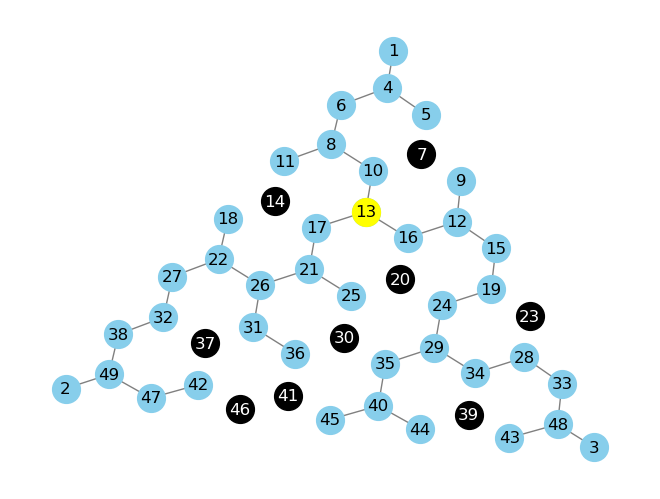

{'len12': 14, 'len13': 16, 'len23': 20, 'reward_path_lengths': [14, 16, 20], 'path_length_difference': 6, 'optimal_paths_12': [[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, 38, 49, 2]], 'optimal_paths_13': [[1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3]], 'optimal_paths_23': [[2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3]], 'optimal_paths_all': [[1, 4, 6, 8, 10, 13, 17, 21, 26, 22, 27, 32, 38, 49, 2], [1, 4, 6, 8, 10, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3], [2, 49, 38, 32, 27, 22, 26, 21, 17, 13, 16, 12, 15, 19, 24, 29, 34, 28, 33, 48, 3]], 'choice_points': {13}, 'num_choice_points': 1}


In [13]:
# get a random maze config for testing
maze_config_list = list(good_mazes)

bars = maze_config_list[0]
# print it and visualize it
print(bars)
plot_hex_maze(bars)

# get attributes of this maze
atts = get_maze_attributes(bars)
print(atts)